## Importing Libraries and Dependencies

In [1]:

import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder,RobustScaler
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import category_encoders as ce   #you many need to: pip install category_encoders
import os
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score
from scipy import stats

In [2]:
feature_encoding = 1  #  0 for skiping categories in evaluation *** 1 for oneHotEncoder ***  2 for TargetEncoder *** 4 for Binary Encoder


## Reading the file into a dataframe

In [3]:
file_path = Path('./Resources/train.csv')
train = pd.read_csv(file_path)
print (f' Data frame size is  {train.shape}')
train.head(5)

 Data frame size is  (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
file_path = Path('./Resources/test.csv')
test = pd.read_csv(file_path)
print (f' Data frame size is  {test.shape}')
test.head(5)

 Data frame size is  (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [5]:
train_cols = train.columns
test_cols = test.columns

common_cols = train_cols.intersection(test_cols)
train_not_test = train_cols.difference(test_cols)
train_not_test

Index(['SalePrice'], dtype='object')

In [6]:
df = train.copy()

## Data Cleaning
* step1 : chekcing NAs in columns
* step2 : updating NAs or missing values
* step3 : checking for outliers
* step4 : bucketing


## Step1: Checking NAs in columns
* 1-1: finding count of NAs in each column
* 1-2: if number of NA is more than 10% then that column is removed.
* 1-3: Checking Rows for NA

In [7]:
df_NA_sum = pd.DataFrame(df.isna().sum())
Columns_NA_COUNT = df_NA_sum.loc[df_NA_sum[0]>0]
print('Part 1-1: Here are the count of NAs in columns')
Columns_NA_COUNT

Part 1-1: Here are the count of NAs in columns


,0
LotFrontage,259
Alley,1369
MasVnrType,8
MasVnrArea,8
BsmtQual,37
BsmtCond,37
BsmtExposure,38
BsmtFinType1,37
BsmtFinType2,38
Electrical,1


In [8]:
perc = 10 # if more than this perc, the columns is dropped.
min_count =  int(((100-perc)/100)*df.shape[0])
df_NAcolumnsdropped = df.dropna( axis=1, thresh=min_count)
print(f'here is the new dataframe size: {df_NAcolumnsdropped.shape}')

dropped_columns = df.columns.difference(df_NAcolumnsdropped.columns).tolist()
print(f'Here is the list of dropped columns: {dropped_columns}')

here is the new dataframe size: (1460, 75)
Here is the list of dropped columns: ['Alley', 'Fence', 'FireplaceQu', 'LotFrontage', 'MiscFeature', 'PoolQC']


#### checking for NAs in rows

In [9]:

print(f'Here is the number of rows that have NA values: {sum(df_NAcolumnsdropped.isnull().sum(axis=1)>0)} and will be dropped')
print(f'{sum(df_NAcolumnsdropped.isnull().sum(axis=1)>0)/len(df_NAcolumnsdropped)*100} percent of data is dropped')
df_NArowsdropped = df_NAcolumnsdropped.dropna(axis=0)
df_NArowsdropped.shape


Here is the number of rows that have NA values: 122 and will be dropped
8.356164383561644 percent of data is dropped


(1338, 75)

In [10]:
print(f'Verifying if the datatypes are correct')
number_of_numerical_columns = len(df_NArowsdropped.select_dtypes('int64').columns)
print(f'Expection is to have 35 numerical columns and we have {number_of_numerical_columns}')

Verifying if the datatypes are correct
Expection is to have 35 numerical columns and we have 35


C:\Users\14078\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


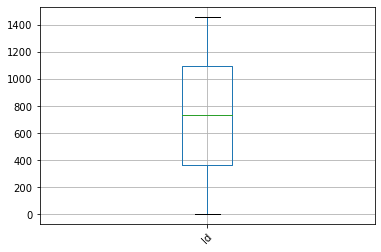

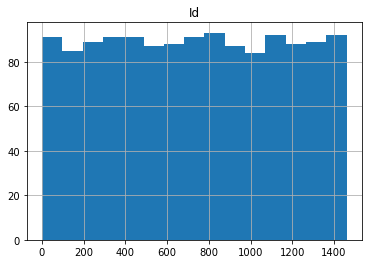

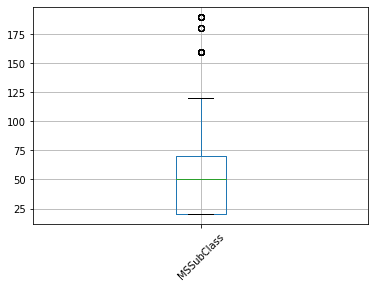

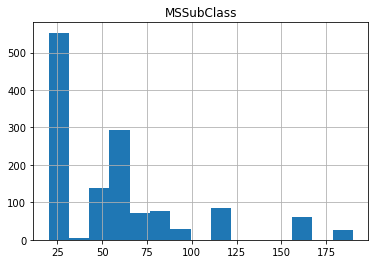

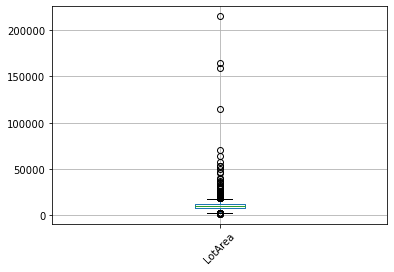

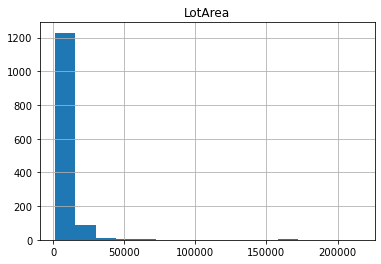

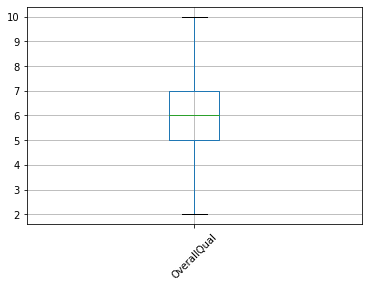

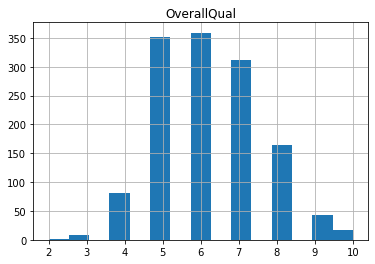

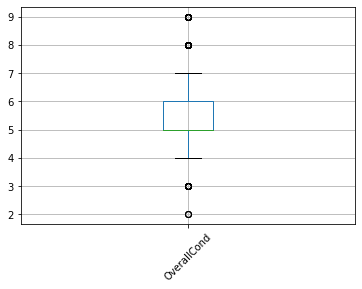

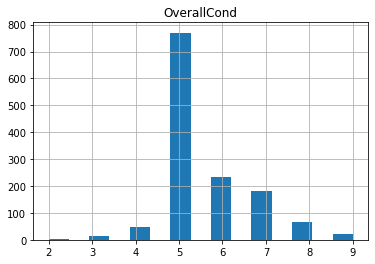

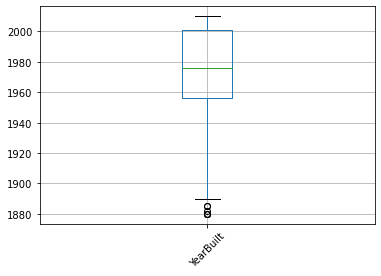

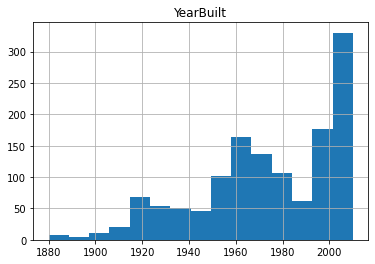

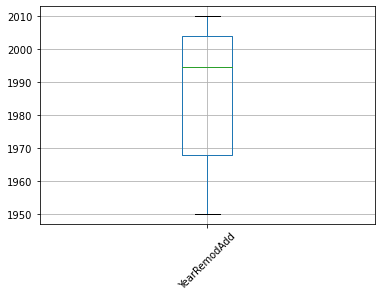

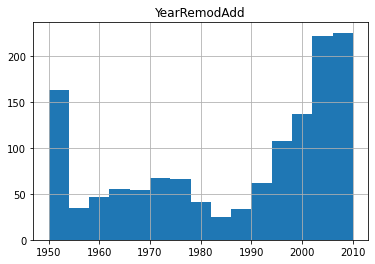

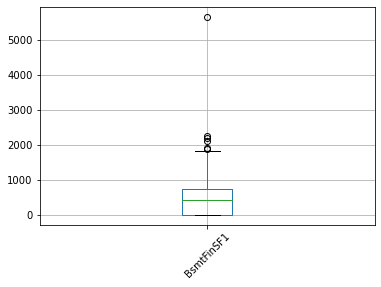

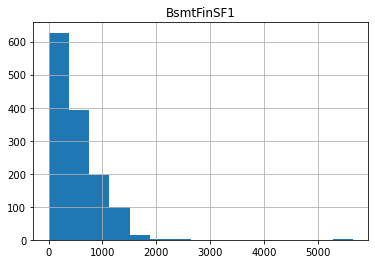

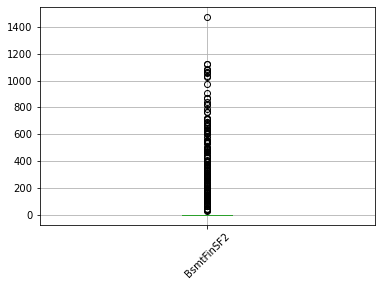

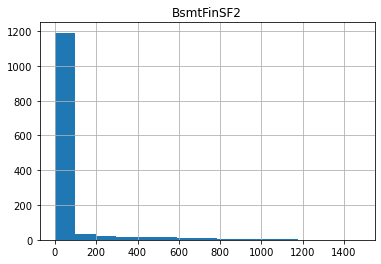

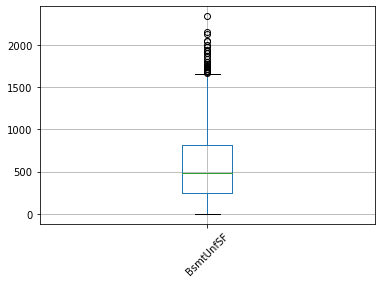

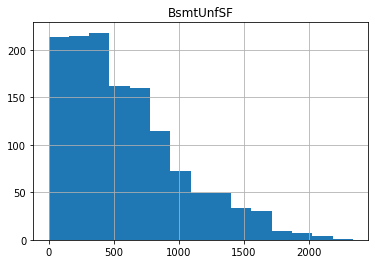

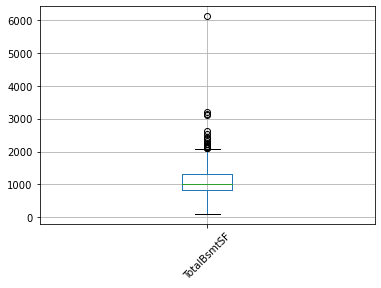

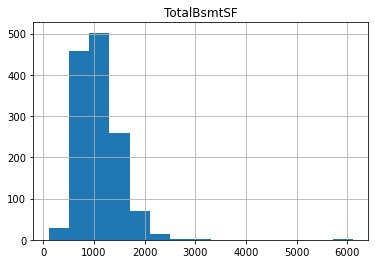

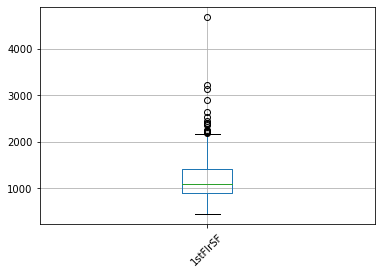

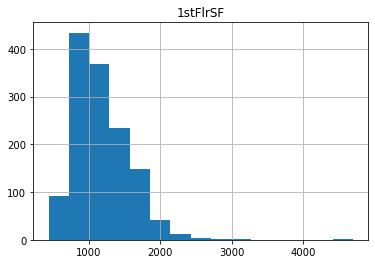

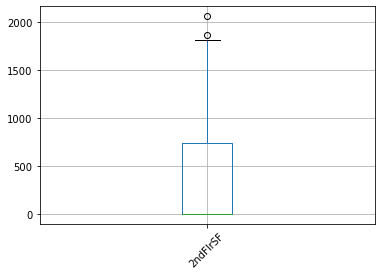

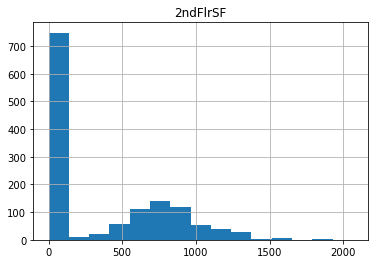

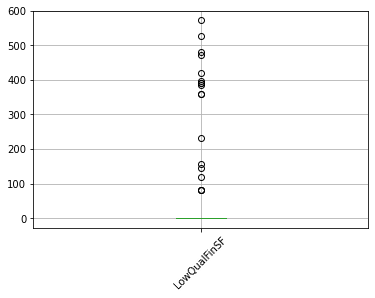

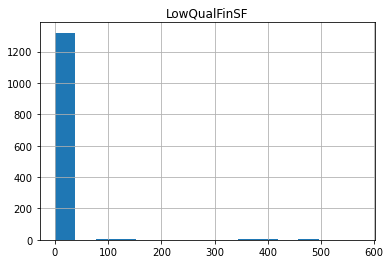

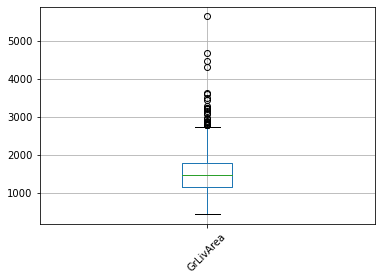

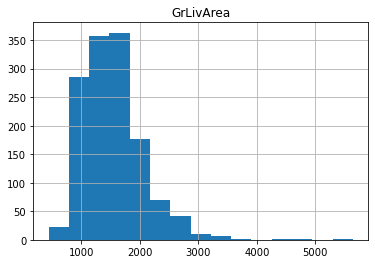

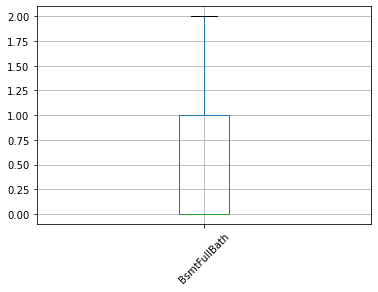

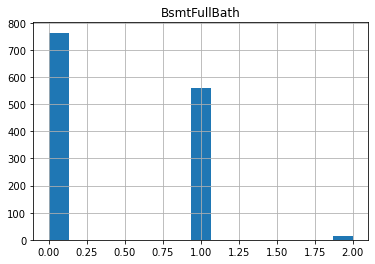

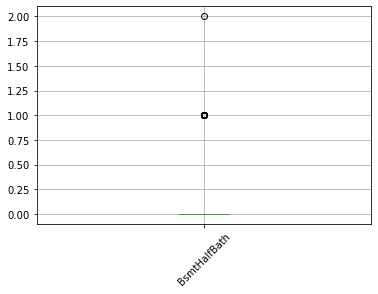

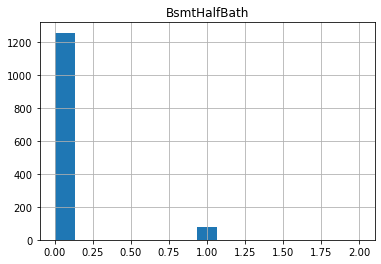

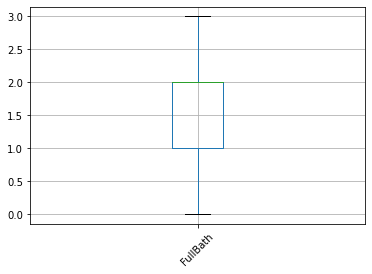

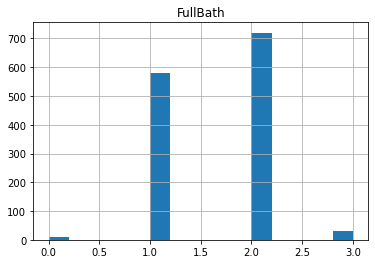

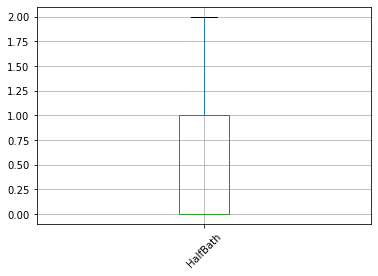

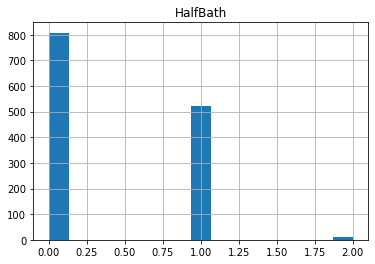

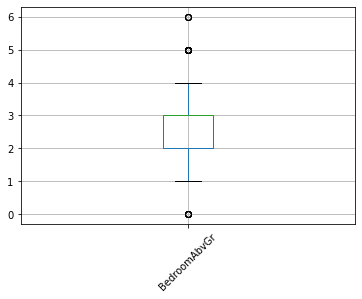

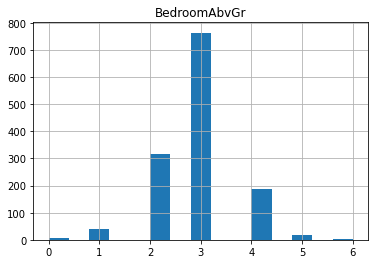

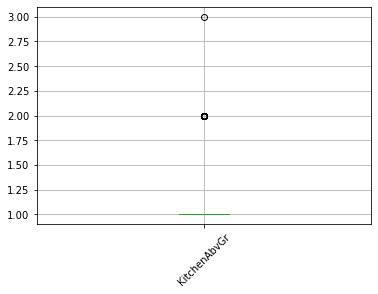

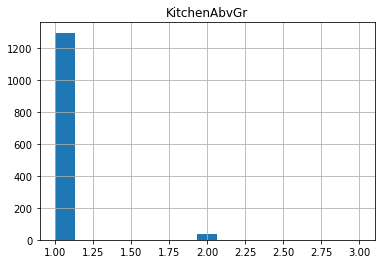

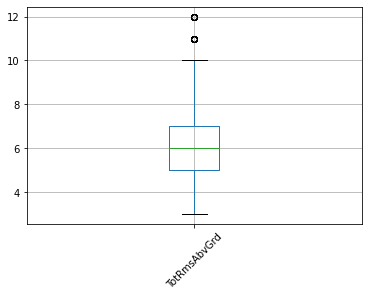

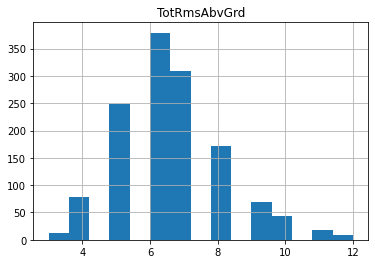

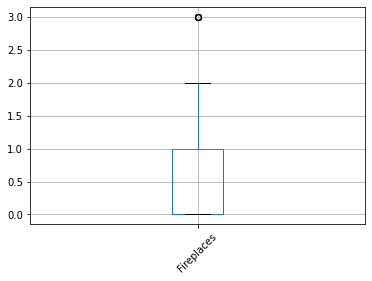

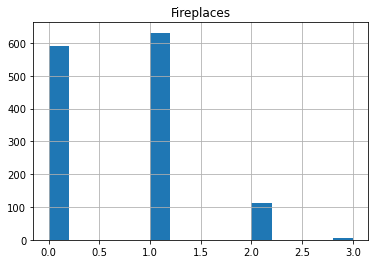

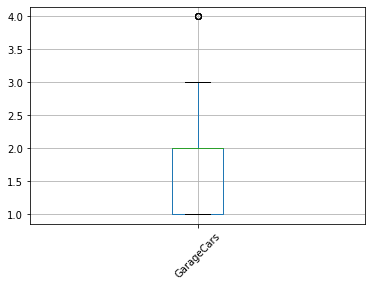

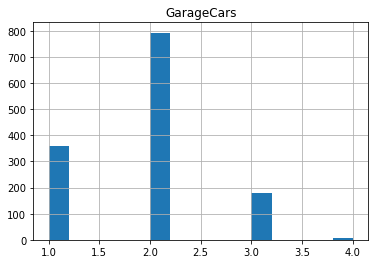

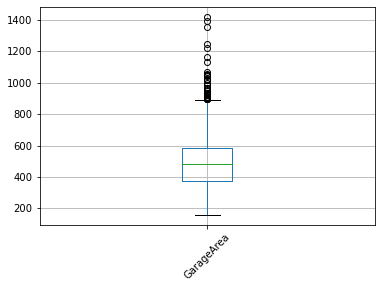

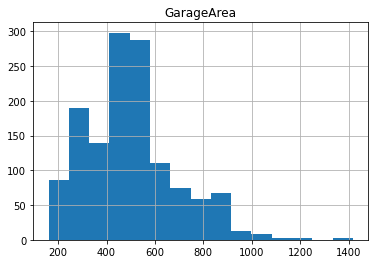

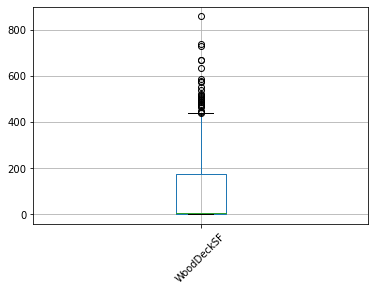

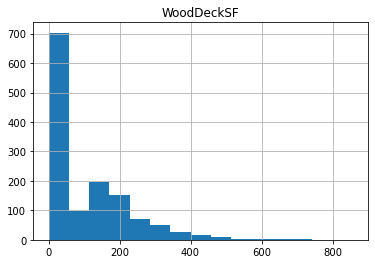

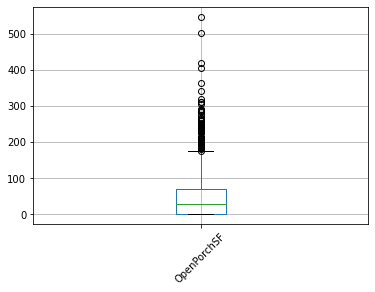

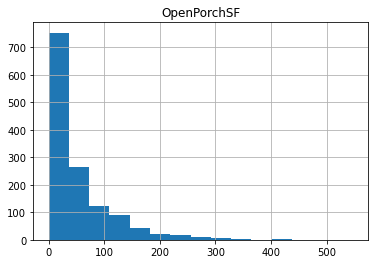

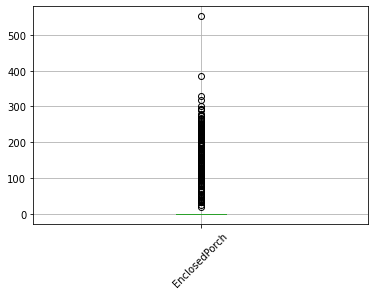

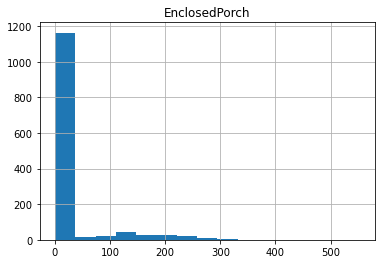

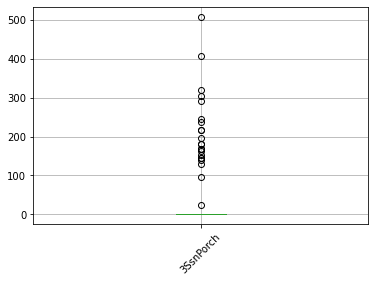

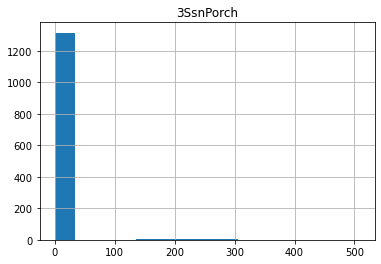

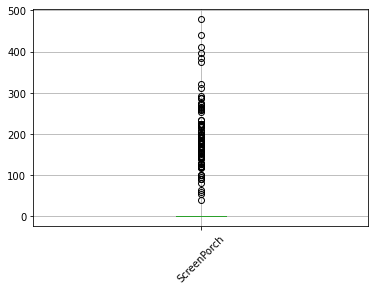

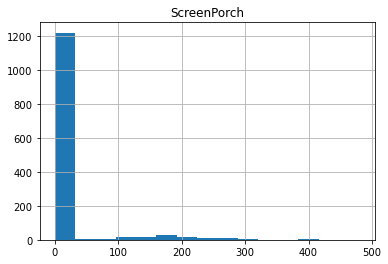

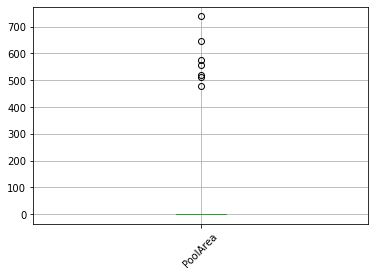

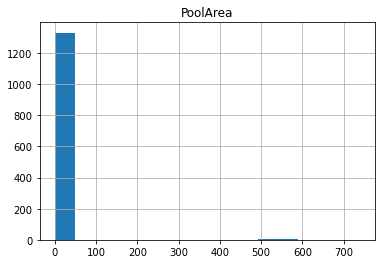

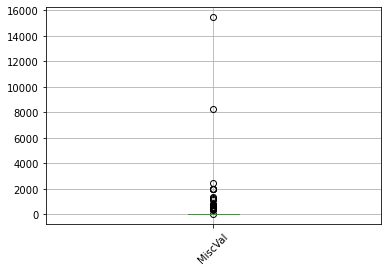

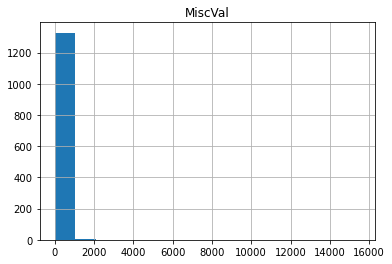

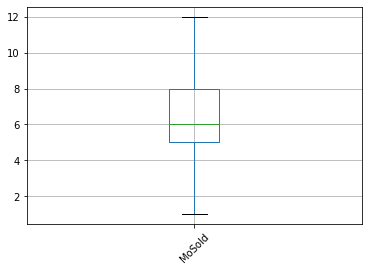

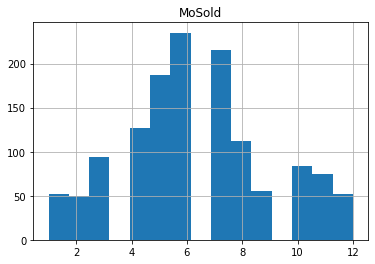

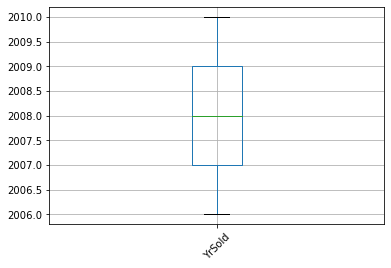

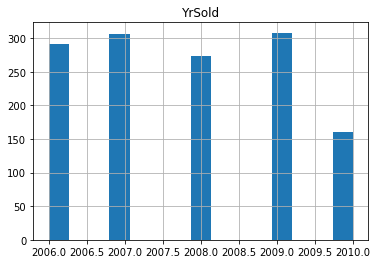

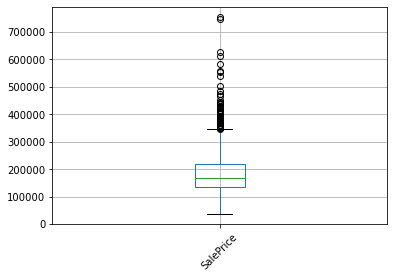

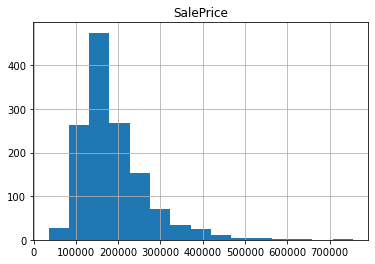

In [11]:
list_numerical_columns = df_NArowsdropped.select_dtypes('int64').columns.tolist()
for box in list_numerical_columns:
    plt.figure()
    df_NArowsdropped.boxplot(column=box,rot=45)
    df_NArowsdropped.hist(column=box,bins =15 )
    

In [12]:
#dropping ID columns
df_readyforencode = df_NArowsdropped.drop(columns="Id")
df_readyforencode.head(5)

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,...,0,0,0,0,0,12,2008,WD,Normal,250000


## ready to encode

In [13]:
# Generate our categorical variable list
df_readyforencode_cat = df_readyforencode.dtypes[df_readyforencode.dtypes == "object"].index.tolist()

print (f'number of categorial columns:{len(df_readyforencode_cat)}')
# Check the number of unique values in each column
df_readyforencode[df_readyforencode_cat].nunique()

number of categorial columns:38


MSZoning          5
Street            2
LotShape          4
LandContour       4
Utilities         2
LotConfig         5
LandSlope         3
Neighborhood     25
Condition1        9
Condition2        8
BldgType          5
HouseStyle        8
RoofStyle         6
RoofMatl          8
Exterior1st      14
Exterior2nd      16
MasVnrType        4
ExterQual         4
ExterCond         4
Foundation        5
BsmtQual          4
BsmtCond          4
BsmtExposure      4
BsmtFinType1      6
BsmtFinType2      6
Heating           4
HeatingQC         5
CentralAir        2
Electrical        5
KitchenQual       4
Functional        7
GarageType        6
GarageFinish      3
GarageQual        5
GarageCond        5
PavedDrive        3
SaleType          9
SaleCondition     6
dtype: int64

In [14]:
list_of_unique_va_cat_dummy = df_readyforencode[df_readyforencode_cat].nunique() > 10
list_of_unique_va_cat=list_of_unique_va_cat_dummy[list_of_unique_va_cat_dummy==True].index.tolist()
print(f'list of features that have more than 10 categories: {list_of_unique_va_cat}')

list of features that have more than 10 categories: ['Neighborhood', 'Exterior1st', 'Exterior2nd']


C:\Users\14078\anaconda3\envs\mlenv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\14078\anaconda3\envs\mlenv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\14078\anaconda3\envs\mlenv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexib

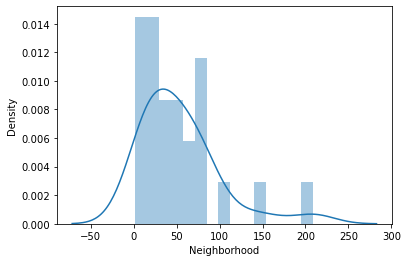

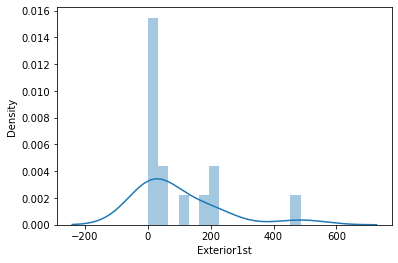

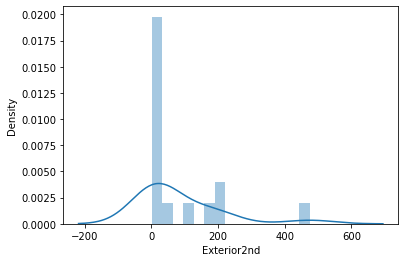

In [15]:
# Visualizing the data using density plot
for col in list_of_unique_va_cat:
#     print( df_readyforencode[col].value_counts())
    plt.figure()
    sns.distplot(a=df_readyforencode[col].value_counts(),bins=15)

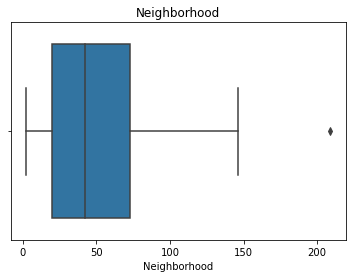

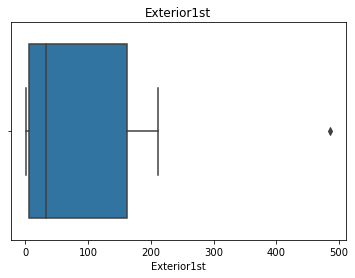

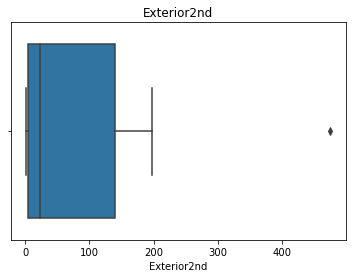

In [16]:
# Visualizing the data in boxplot format
for col in list_of_unique_va_cat:
#     print( df_readyforencode[col].value_counts())
    plt.figure()
#     df_readyforencode[col].value_counts().plot.density()
#     df_readyforencode[col].value_counts().hist()
    plt.title(col)
    ax = sns.boxplot(x=df_readyforencode[col].value_counts())
    
    



In [17]:
# %%%%%%% need to bin here for 3 columns

def replace_col_data_for_binning(df,col,limit):
    col_val_count = df[col].value_counts()
    replace_col_data = list(col_val_count[col_val_count<limit].index)
    for data in replace_col_data:
        df[col]= df[col].replace(data,"Other")
    return df

df_readyforencode1 = df_readyforencode.copy()    

print(list_of_unique_va_cat)

replace_col_data_for_binning(df_readyforencode1,list_of_unique_va_cat[0],20)
replace_col_data_for_binning(df_readyforencode1,list_of_unique_va_cat[1],40)
replace_col_data_for_binning(df_readyforencode1,list_of_unique_va_cat[2],40)




['Neighborhood', 'Exterior1st', 'Exterior2nd']


,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Other,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,...,0,0,0,0,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,7917,Pave,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,...,0,0,0,0,0,8,2007,WD,Normal,175000
1456,20,RL,13175,Pave,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,...,0,0,0,0,0,2,2010,WD,Normal,210000
1457,70,RL,9042,Pave,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,...,0,0,0,0,2500,5,2010,WD,Normal,266500
1458,20,RL,9717,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,...,112,0,0,0,0,4,2010,WD,Normal,142125


In [18]:
df_readyforencode1[list_of_unique_va_cat[2]].value_counts()

VinylSd    475
MetalSd    197
HdBoard    197
Wd Sdng    176
Plywood    127
Other      115
CmentBd     51
Name: Exterior2nd, dtype: int64

In [19]:
df_readyforencode[list_of_unique_va_cat[2]].value_counts()

VinylSd    475
MetalSd    197
HdBoard    197
Wd Sdng    176
Plywood    127
CmentBd     51
Wd Shng     32
Stucco      23
BrkFace     22
AsbShng     16
ImStucc     10
Brk Cmn      6
AsphShn      2
Stone        2
Other        1
CBlock       1
Name: Exterior2nd, dtype: int64

## here is option 1 for encoding : using oneHotencoder

In [20]:
if feature_encoding == 1 :
    
    # Create a OneHotEncoder instance
    enc = OneHotEncoder(sparse=False)



    # Fit and transform the OneHotEncoder using the categorical variable list
    encode_df = pd.DataFrame(enc.fit_transform(df_readyforencode1[df_readyforencode_cat]))

    # Add the encoded variable names to the DataFrame
    encode_df.columns = enc.get_feature_names(df_readyforencode_cat)
    print(encode_df)


      MSZoning_C (all)  MSZoning_FV  MSZoning_RH  MSZoning_RL  MSZoning_RM  \
0                  0.0          0.0          0.0          1.0          0.0   
1                  0.0          0.0          0.0          1.0          0.0   
2                  0.0          0.0          0.0          1.0          0.0   
3                  0.0          0.0          0.0          1.0          0.0   
4                  0.0          0.0          0.0          1.0          0.0   
...                ...          ...          ...          ...          ...   
1333               0.0          0.0          0.0          1.0          0.0   
1334               0.0          0.0          0.0          1.0          0.0   
1335               0.0          0.0          0.0          1.0          0.0   
1336               0.0          0.0          0.0          1.0          0.0   
1337               0.0          0.0          0.0          1.0          0.0   

      Street_Grvl  Street_Pave  LotShape_IR1  LotShape_IR2  Lot

### it looks like there are way too many columns above using onehotencoder


In [21]:
if feature_encoding ==1 :
    print(f'number of columns after OneHOTEncoding is :{len(encode_df.columns)}')

number of columns after OneHOTEncoding is :209


## In the below section we merge the encoded columns and drop the copies

In [22]:
if feature_encoding == 1 :
    df_readyforencode1 = df_readyforencode1.merge(encode_df,left_index=True, right_index=True)
    df_ready_final = df_readyforencode1.drop(df_readyforencode_cat,1)
    print(df_ready_final.head())

   MSSubClass  LotArea  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
0          60     8450            7            5       2003          2003   
1          20     9600            6            8       1976          1976   
2          60    11250            7            5       2001          2002   
3          70     9550            7            5       1915          1970   
4          60    14260            8            5       2000          2000   

   MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  ...  SaleType_ConLw  \
0       196.0         706           0        150  ...             0.0   
1         0.0         978           0        284  ...             0.0   
2       162.0         486           0        434  ...             0.0   
3         0.0         216           0        540  ...             0.0   
4       350.0         655           0        490  ...             0.0   

   SaleType_New  SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  \
0           0.0           0.0

C:\Users\14078\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


## Option 0: skipping categories (feature_encoding =0)

In [23]:

if feature_encoding ==0 :
    df_readyforencode0 = df_readyforencode.copy()
    df_readyforencode0=df_readyforencode0.drop(df_readyforencode_cat,axis=1)
#     df_readyforencode2.shape
    # df_readyforencode.shape
    # df_readyforencode_cat
    df_ready_final = df_readyforencode0
    print(f'skipping all the catergories has this many columns: {len(df_ready_final.columns)}')

## Option 2: Mean Encoding (feature_encoding =2)

In [24]:
if feature_encoding == 2:
    df_readyforencode2 = df_readyforencode.copy()
    for col in df_readyforencode_cat:
        df_readyforencode2[col] = df_readyforencode2[col].map(df.groupby(col)['SalePrice'].mean())

    df_ready_final = df_readyforencode2
    print(f'Mean Encodign has this many columns: {len(df_ready_final.columns)}')

## Option 3: Median Encoding (feature_encoding =3)


In [25]:
if feature_encoding == 3:
    df_readyforencode3 = df_readyforencode.copy()
    for col in df_readyforencode_cat:
        df_readyforencode3[col] = df_readyforencode3[col].map(df.groupby(col)['SalePrice'].median())

    df_ready_final = df_readyforencode3
    print(f'Mean Encodign has this many columns: {len(df_ready_final.columns)}')

## Option 4: Binary Encoding (feature_encoding =4)


In [26]:

if feature_encoding == 4:
    
    df_readyforencode4 = df_readyforencode.copy()  
    ce_bin = ce.BinaryEncoder()
    # ce_bin.fit_transform(X, y)
    # encode_df = pd.DataFrame(ce_bin.fit_transform(df_readyforencode4[df_readyforencode_cat]))

    df_ready_final = pd.DataFrame(ce_bin.fit_transform(df_readyforencode4))

    print(f'Bianary Encodign has this many columns: {len(df_ready_final.columns)}')
    print(df_ready_final)

## splitting input and output

In [27]:
y = df_ready_final['SalePrice']
X = df_ready_final.drop(columns=['SalePrice'])
X.shape

(1223, 244)

## Splitting Traing and Test data

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
# , stratify=y

## Scaling the input data

In [29]:
# Create a Robust instance
scaler = RobustScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Setting up Deep Neural Network

In [30]:


# Define the checkpoint path and filenames
os.makedirs("checkpoints/",exist_ok=True)
checkpoint_path = "checkpoints/weights.{epoch:02d}.hdf5"
# Create a callback that saves the model's weights every epoch
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=5*804,
     )

In [31]:
number_input_features = len(X_train_scaled[0])
number_input_features

244

In [32]:
print(f'X_train_scaled:{X_train_scaled.shape}')
print(f'X_test_scaled:{X_test_scaled.shape}')
print(f'y:{y.shape}')

X_train_scaled:(917, 244)
X_test_scaled:(306, 244)
y:(1223,)


In [33]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.

number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 = 250
hidden_nodes_layer2 = 120
hidden_nodes_layer3 = 10
hidden_nodes_layer4 = 10

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="relu"))

# nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer4, activation="relu"))


# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="relu"))

# Check the structure of the model
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 250)               61250     
                                                                 
 dense_1 (Dense)             (None, 120)               30120     
                                                                 
 dense_2 (Dense)             (None, 1)                 121       
                                                                 
Total params: 91,491
Trainable params: 91,491
Non-trainable params: 0
_________________________________________________________________


In [34]:
# Compile the model
# nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
nn.compile(loss="mean_squared_error", optimizer="adam") #since we are doing regression

In [35]:
fit_model = nn.fit(X_train_scaled, y_train, epochs=600,callbacks=[cp_callback])

Epoch 1/600
29/29 [==============================] - 1s 3ms/step - loss: 41904693248.0000
Epoch 2/600
29/29 [==============================] - 0s 3ms/step - loss: 41753010176.0000
Epoch 3/600
29/29 [==============================] - 0s 3ms/step - loss: 41259085824.0000
Epoch 4/600
29/29 [==============================] - 0s 3ms/step - loss: 40181915648.0000
Epoch 5/600
29/29 [==============================] - 0s 3ms/step - loss: 38399324160.0000
Epoch 6/600
29/29 [==============================] - 0s 3ms/step - loss: 36423815168.0000
Epoch 7/600
29/29 [==============================] - 0s 3ms/step - loss: 34302117888.0000
Epoch 8/600
29/29 [==============================] - 0s 4ms/step - loss: 32394741760.0000
Epoch 9/600
29/29 [==============================] - 0s 3ms/step - loss: 30692251648.0000
Epoch 10/600
29/29 [==============================] - 0s 3ms/step - loss: 28969938944.0000
Epoch 11/600
29/29 [==============================] - 0s 3ms/step - loss: 27299315712.0000
Epoch 12

29/29 [==============================] - 0s 3ms/step - loss: 1443445632.0000
Epoch 92/600
29/29 [==============================] - 0s 3ms/step - loss: 1424853632.0000
Epoch 93/600
29/29 [==============================] - 0s 3ms/step - loss: 1417536256.0000
Epoch 94/600
29/29 [==============================] - 0s 3ms/step - loss: 1403309312.0000
Epoch 95/600
29/29 [==============================] - 0s 3ms/step - loss: 1424307584.0000
Epoch 96/600
29/29 [==============================] - 0s 3ms/step - loss: 1422335744.0000
Epoch 97/600
29/29 [==============================] - 0s 3ms/step - loss: 1432862336.0000
Epoch 98/600
29/29 [==============================] - 0s 3ms/step - loss: 1415606016.0000
Epoch 99/600
29/29 [==============================] - 0s 3ms/step - loss: 1381027712.0000
Epoch 100/600
29/29 [==============================] - 0s 3ms/step - loss: 1360498944.0000
Epoch 101/600
29/29 [==============================] - 0s 3ms/step - loss: 1371732608.0000
Epoch 102/600
29/29 [

29/29 [==============================] - 0s 3ms/step - loss: 1019318784.0000
Epoch 180/600
29/29 [==============================] - 0s 3ms/step - loss: 1030666816.0000
Epoch 181/600
29/29 [==============================] - 0s 3ms/step - loss: 1013464832.0000
Epoch 182/600
29/29 [==============================] - 0s 3ms/step - loss: 1014057472.0000
Epoch 183/600
29/29 [==============================] - 0s 3ms/step - loss: 1028534336.0000
Epoch 184/600
29/29 [==============================] - 0s 3ms/step - loss: 1001566912.0000
Epoch 185/600
29/29 [==============================] - 0s 2ms/step - loss: 992638848.0000
Epoch 186/600
29/29 [==============================] - 0s 3ms/step - loss: 980938176.0000
Epoch 187/600
29/29 [==============================] - 0s 3ms/step - loss: 992220160.0000
Epoch 188/600
29/29 [==============================] - 0s 2ms/step - loss: 1113136256.0000
Epoch 189/600
29/29 [==============================] - 0s 3ms/step - loss: 1007408640.0000
Epoch 190/600
29

29/29 [==============================] - 0s 3ms/step - loss: 809352384.0000
Epoch 271/600
29/29 [==============================] - 0s 3ms/step - loss: 789374976.0000
Epoch 272/600
29/29 [==============================] - 0s 3ms/step - loss: 809427712.0000
Epoch 273/600
29/29 [==============================] - 0s 3ms/step - loss: 815860992.0000
Epoch 274/600
29/29 [==============================] - 0s 3ms/step - loss: 828345536.0000
Epoch 275/600
29/29 [==============================] - 0s 3ms/step - loss: 811738688.0000
Epoch 276/600
29/29 [==============================] - 0s 3ms/step - loss: 796932416.0000
Epoch 277/600
29/29 [==============================] - 0s 3ms/step - loss: 789841344.0000
Epoch 278/600
 1/29 [>.............................] - ETA: 0s - loss: 2926682368.0000
Epoch 278: saving model to checkpoints\weights.278.hdf5
29/29 [==============================] - 0s 4ms/step - loss: 894326848.0000
Epoch 279/600
29/29 [==============================] - 0s 3ms/step - loss: 

29/29 [==============================] - 0s 3ms/step - loss: 655356160.0000
Epoch 360/600
29/29 [==============================] - 0s 3ms/step - loss: 649422720.0000
Epoch 361/600
29/29 [==============================] - 0s 3ms/step - loss: 652851904.0000
Epoch 362/600
29/29 [==============================] - 0s 3ms/step - loss: 641433024.0000
Epoch 363/600
29/29 [==============================] - 0s 3ms/step - loss: 631179840.0000
Epoch 364/600
29/29 [==============================] - 0s 3ms/step - loss: 628185280.0000
Epoch 365/600
29/29 [==============================] - 0s 3ms/step - loss: 628067520.0000
Epoch 366/600
29/29 [==============================] - 0s 3ms/step - loss: 625089216.0000
Epoch 367/600
29/29 [==============================] - 0s 3ms/step - loss: 624161024.0000
Epoch 368/600
29/29 [==============================] - 0s 3ms/step - loss: 618759296.0000
Epoch 369/600
29/29 [==============================] - 0s 3ms/step - loss: 611942912.0000
Epoch 370/600
29/29 [===

29/29 [==============================] - 0s 3ms/step - loss: 526591264.0000
Epoch 449/600
29/29 [==============================] - 0s 3ms/step - loss: 511053760.0000
Epoch 450/600
29/29 [==============================] - 0s 3ms/step - loss: 520044608.0000
Epoch 451/600
29/29 [==============================] - 0s 3ms/step - loss: 533659648.0000
Epoch 452/600
29/29 [==============================] - 0s 3ms/step - loss: 522010144.0000
Epoch 453/600
29/29 [==============================] - 0s 3ms/step - loss: 508938368.0000
Epoch 454/600
29/29 [==============================] - 0s 3ms/step - loss: 495367424.0000
Epoch 455/600
29/29 [==============================] - 0s 3ms/step - loss: 501861472.0000
Epoch 456/600
29/29 [==============================] - 0s 3ms/step - loss: 525805216.0000
Epoch 457/600
29/29 [==============================] - 0s 3ms/step - loss: 500526944.0000
Epoch 458/600
29/29 [==============================] - 0s 3ms/step - loss: 516358240.0000
Epoch 459/600
29/29 [===

29/29 [==============================] - 0s 3ms/step - loss: 415536576.0000
Epoch 540/600
29/29 [==============================] - 0s 3ms/step - loss: 412575776.0000
Epoch 541/600
29/29 [==============================] - 0s 3ms/step - loss: 432528000.0000
Epoch 542/600
29/29 [==============================] - 0s 3ms/step - loss: 439274624.0000
Epoch 543/600
29/29 [==============================] - 0s 4ms/step - loss: 453249856.0000
Epoch 544/600
29/29 [==============================] - 0s 4ms/step - loss: 447374432.0000
Epoch 545/600
29/29 [==============================] - 0s 3ms/step - loss: 431420160.0000
Epoch 546/600
29/29 [==============================] - 0s 3ms/step - loss: 502761088.0000
Epoch 547/600
29/29 [==============================] - 0s 3ms/step - loss: 494287264.0000
Epoch 548/600
29/29 [==============================] - 0s 3ms/step - loss: 416464736.0000
Epoch 549/600
29/29 [==============================] - 0s 3ms/step - loss: 422706048.0000
Epoch 550/600
29/29 [===

In [38]:
model_loss = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss on the Test Dataset: {model_loss}")


10/10 - 0s - loss: 1861735936.0000 - 41ms/epoch - 4ms/step
Loss on the Test Dataset: 1861735936.0


29/29 [==============================] - 0s 2ms/step


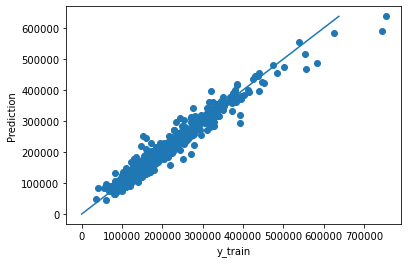

R2 Score on the test dataset using RandomForestRegressor: 0.9455616327221137


In [41]:
predictions_mod = nn.predict(X_train_scaled)
predictions=predictions_mod.reshape(-1)
t = np.arange(0,max(predictions),100)
plt.scatter(y_train,predictions)
plt.plot(t,t)
plt.xlabel('y_train')
plt.ylabel('Prediction')
plt.show()
print(f'R2 Score on the test dataset using RandomForestRegressor: {r2_score(y_train, predictions)}')

10/10 [==============================] - 0s 2ms/step


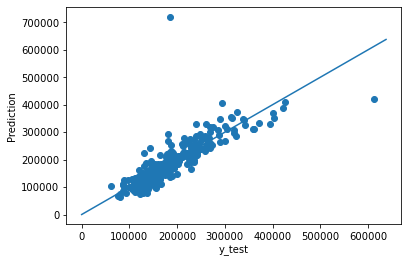

R2 Score on the test dataset using DNN: 0.6161726292244272


In [42]:
predictions_mod = nn.predict(X_test_scaled)
predictions=predictions_mod.reshape(-1)
plt.scatter(y_test,predictions)
plt.plot(t,t)
plt.xlabel('y_test')
plt.ylabel('Prediction')
plt.show()
print(f'R2 Score on the test dataset using DNN: {r2_score(y_test, predictions)}')

In [49]:
gg=predictions.reshape(-1)
predictions.shape

(306,)

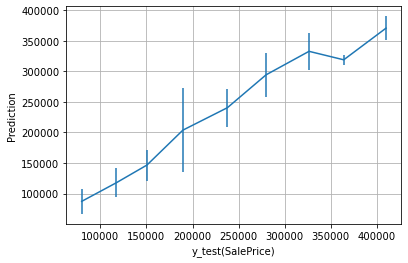

In [51]:
bins = np.linspace(0, max(y_test), 15)
digitized = np.digitize(y_test, bins)

DNN_Res = pd.DataFrame(y_test)
DNN_Res['pred'] =predictions
DNN_Res["bins"] = digitized
DNN_Res['error'] = (predictions-y_test)
DNN_Res_mean = DNN_Res.groupby(['bins']).mean()
DNN_Res_std =DNN_Res.groupby(['bins']).std()

plt.errorbar(DNN_Res_mean['SalePrice'][:-1],DNN_Res_mean['pred'][:-1],DNN_Res_std['error'][:-1])
plt.xlabel('y_test(SalePrice)')
plt.ylabel('Prediction')
plt.grid()

Text(0.5, 1.0, 'Error in percentage in house Price Prediction')

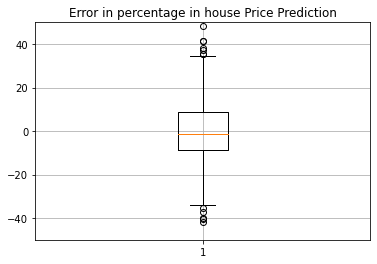

In [52]:
error_perc = (predictions-y_test)/y_test*100
plt.boxplot(error_perc)
plt.ylim([-50,50])
plt.grid()
plt.title('Error in percentage in house Price Prediction')

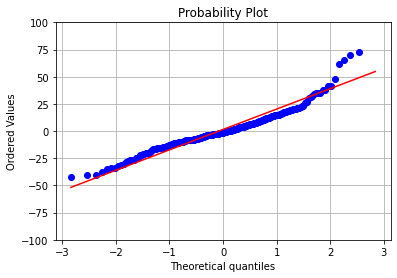

In [53]:
res = stats.probplot(error_perc, plot=plt)
plt.grid()
plt.ylim([-100,100])
plt.show()

# Adding RandomForestRegressor
from scikit learn

In [54]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [55]:
using_Randomizedsearch_forRandom = 0
if using_Randomizedsearch_forRandom==0:
    # regr = RandomForestRegressor(n_estimators=500,max_depth=100, random_state=0)
    regr = RandomForestRegressor()

    regr.fit(X_train_scaled, y_train)

In [56]:
if using_Randomizedsearch_forRandom==1:
    rf = RandomForestRegressor()
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 20, cv = 3, verbose=2, random_state=42, n_jobs = -1)
    # Fit the random search model
    rf_random.fit(X_train_scaled, y_train)

Loss on the test dataset using RandomForestRegressor: 1096589639.8809369
R2 Score on the test dataset using RandomForestRegressor: 0.7739200768730643


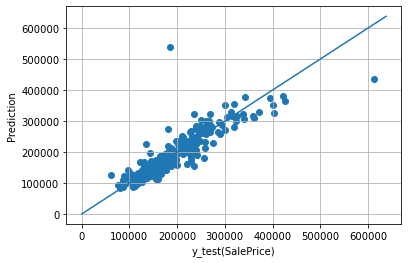

In [57]:

predictions = regr.predict(X_test_scaled)
print(f'Loss on the test dataset using RandomForestRegressor: {mean_squared_error(y_test, predictions)}')
print(f'R2 Score on the test dataset using RandomForestRegressor: {r2_score(y_test, predictions)}')

plt.scatter(y_test,predictions)
plt.plot(t,t)
plt.xlabel('y_test(SalePrice)')
plt.ylabel('Prediction')
plt.grid()
plt.show()#

In [58]:
bins = np.linspace(0, max(y_test), 15)
digitized = np.digitize(y_test, bins)

RF_Res = pd.DataFrame(y_test)
RF_Res['pred'] =predictions
RF_Res["bins"] = digitized
RF_Res['error'] = (predictions-y_test)
RF_Res_mean = gg.groupby(['bins']).mean()
RF_Res_std =gg.groupby(['bins']).std()

plt.errorbar(RF_Res_mean['SalePrice'][:-1],RF_Res_mean['pred'][:-1],RF_Res_std['error'][:-1])
plt.xlabel('y_test(SalePrice)')
plt.ylabel('Prediction')
plt.grid()

AttributeError: 'numpy.ndarray' object has no attribute 'groupby'

In [ ]:
error_perc = (predictions-y_test)/y_test*100
plt.boxplot(error_perc)
plt.ylim([-50,50])
plt.grid()
plt.title('Error in percentage in house Price Prediction')


In [ ]:
plt.scatter(y_test,error_perc)
# plt.plot(t,t)
plt.xlabel('y_test')
plt.ylabel('Prediction')
plt.ylim([-50,50])
plt.grid()
plt.show()#

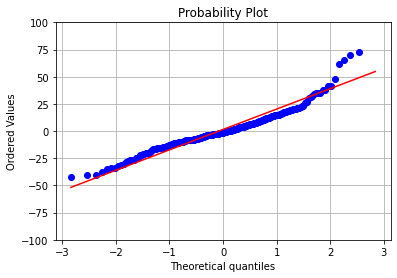

In [59]:

res = stats.probplot(error_perc, plot=plt)
plt.grid()
plt.ylim([-100,100])
plt.show()


## This part checks for feature importance

In [60]:
# regr.feature_importances_

## Next section plots sorted feature importance  ( only TOP 15 important Features)

<AxesSubplot:>

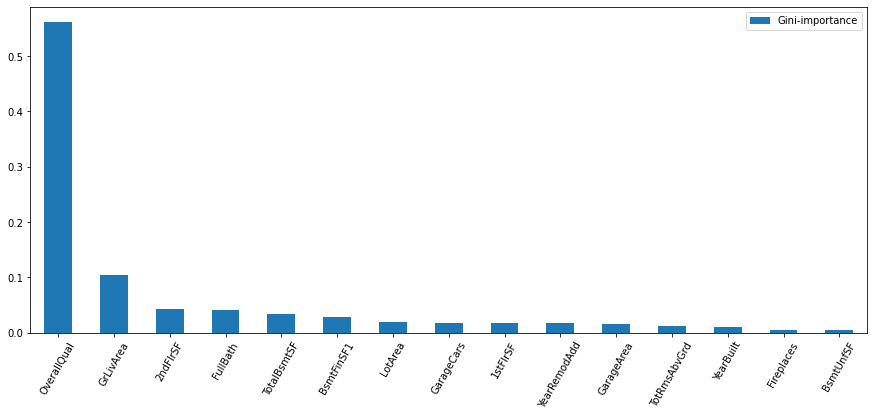

In [61]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X.columns, regr.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance',ascending = False).head(15).plot(kind='bar', rot=60,figsize=(15,6))